In [55]:
# By Joachim Harnois-Deraps, with inputs from Ben Giblin on the galaxy populatio algorithm, 
# and Nan Li on some lensing subroutines 
# Code illustrating extraction of shear from Mira Titan/SkySim5000 healpix maps

import numpy as np
import healpy as hp
import random
import input

SkySim=True
HACCY1=False


# The tomographic bin
tomobin = 5

print("**************************")
print("Processing tomo bin",tomobin)
print("**************************")



# the number of galaxies per square arcminute to extract
gpam = 0.06
#gpam = 2.6    #LSST, per tomo bin
#gpam = 1.493  #KiDS tomo4
#gpam = 1.830  #KiDS tomo3
#gpam = 1.856  #KiDS tomo2
#gpam = 2.354  #KiDS tomo1

print('assigning %f gal/arcmin**2' % gpam)
#zs = 2.9412

# the number of galaxies to extract in the octant
ngal = int(gpam * (4.*np.pi/8.)*(180./np.pi)**2. *3600.)
print('for a total of %i galaxies' % ngal)

# The NSIDE value of the shear and weight maps
if(SkySim):
    nside = 8192
if(HACCY1):
    nside = 4096

npix = 12*nside**2
pix_size = np.sqrt(4.*np.pi*(180./np.pi*60)**2/npix)
print('pixel size of shear maps is %f arcmin per side' % pix_size)

def IndexToDeclRa(index):
        theta,phi=hp.pixelfunc.pix2ang(nside,index,nest=False)
        return np.degrees(np.pi/2. - theta),np.degrees(phi)

**************************
Processing tomo bin 5
**************************
assigning 0.060000 gal/arcmin**2
for a total of 1113829 galaxies
pixel size of shear maps is 0.429436 arcmin per side


In [56]:
print("Reading in N(z) from tomobin  %d" % tomobin)
data = np.loadtxt('./Euclid_dndz_fu08_bin1-5.dat', usecols=(0,tomobin)) 

z_array = data[:,0]
pdz = data[:,1]
dz = z_array[41] - z_array[40]
n_zbins = np.size(pdz)

# Normalise:
pdz = pdz/sum(pdz)/dz
print("Check normalisation: sum n(z) dz = ",sum(pdz)*dz)
print("Mean redshift = ", np.dot(pdz,z_array)*dz)

Reading in N(z) from tomobin  5
Check normalisation: sum n(z) dz =  0.9999999999999996
Mean redshift =  1.8520806427544032


In [57]:
#construct cumulative distribution
cumul_dist = np.zeros(n_zbins)

#for z_bin in range(0,10):
for z_bin in range(0,n_zbins):
    #print z_array[z_bin], pdz[z_bin], sum(pdz[0:z_bin+1])
    cumul_dist[z_bin] = sum(pdz[0:z_bin+1])/sum(pdz)
    #print(z_array[z_bin], pdz[z_bin], cumul_dist[z_bin])

    #do ii =1,nbins_pdf
    #  if(rand .lt. cumul_dist(ii))then
    #     photo_bin = ii
    #     exit
    #  endif
    #enddo
    #print ran_array, np.mean(ran_array), np.std(ran_array)

print('Got cumul dist')

Got cumul dist


In [58]:
#draw the galaxies from this n(z) (This routine may take a few seconds to execute)
spec_z = np.zeros(ngal)

#for gal in range(0,20):
for gal in range(0,ngal):
    gal_bin = 0
    ran = random.uniform(0, 1)
    for z_bin in range(0,n_zbins):
        #print ran, cumul_dist[z_bin]
        if ran < cumul_dist[z_bin]:
            gal_bin = z_bin
            break
    #
    #print(gal, ran, cumul_dist[gal_bin-1], cumul_dist[gal_bin], gal_bin, z_bin)
    #
    #
    #randomize distribution within that bin
    ran2 = random.uniform(0,1)*dz
    spec_z[gal] = z_array[gal_bin]+ran2
    #spec_z[gal] = z_array[gal_bin]+dz
    #print( gal, gal_bin, z_array[gal_bin], spec_z[gal],z_array[gal_bin+1])


print('Assigned redshift to these galaxies')
print('-----------------------------------')

Assigned redshift to these galaxies
-----------------------------------


/tmp/ipykernel_41560/1275808357.py:25: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(0, 5,0)


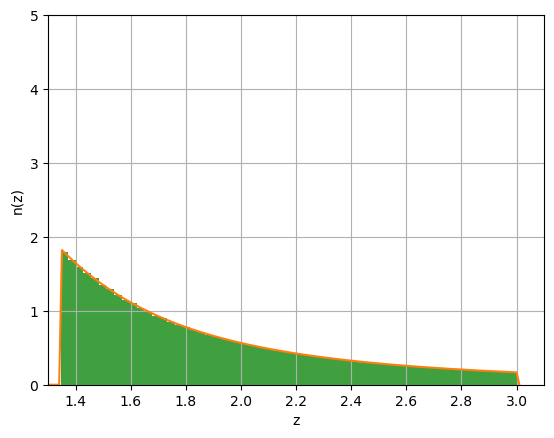

In [59]:
# Plot input n(z) vs galaxy histogram
import matplotlib.pyplot as plt
# the histogram of the data
n, bins, patches = plt.hist(spec_z, 60, density=True, facecolor='g',alpha=0.75)
plt.xlabel('z')
plt.ylabel('n(z)')
#plt.text(60, .025, r'tomobin 1')
plt.grid(True)

plt.plot(z_array+dz/2, pdz)
if tomobin==1: 
    plt.xlim(0, 0.5)
    plt.ylim(0, 4,0)
elif tomobin==2: 
    plt.xlim(0.45, 0.85)
    plt.ylim(0, 5,0)
elif tomobin==3: 
    plt.xlim(0.65, 1.05)
    plt.ylim(0, 5,0)
elif tomobin==4: 
    plt.xlim(0.95, 1.45)
    plt.ylim(0, 5,0)
elif tomobin==5: 
    plt.xlim(1.3, 3.10)
    plt.ylim(0, 5,0)








plt.show()




In [ ]:
# For SkySim5000:
if(SkySim):

    import random


    #find galaxies with shear planes i and j, load the maps, interpolate, loop over next maps
    #z_list = np.loadtxt('list_zs.dat')

    # Selection population option:
    # 1 = randomly choose pixels from the unmasked section of the map
    # 2 = randomly generate angular coords from the unmasked octant (more accurate than OPTION 1)
    # 3 = load mass sheet and populate the galaxies following a linear biasing scheme
    OPTION=3


    zfile=np.loadtxt("z2ts.txt",delimiter=',')
    snaplist = np.flip(zfile[1:58,1]).astype(int)
    z_list=np.flip(zfile[1:58,0])

    n_slices = np.size(z_list)
    #print(zfile)
    #print(z_list)

    ngal_cur = np.zeros(n_slices, dtype=int)

    ngal_analyzed = 0
    weight_flag = 0
    recycle_map_flag = 0

    # Loop over all planes, starting from high redshift towards z=0
    for plane in range(0,n_slices):
    #for plane in range(0,n_slices):

        print('starting analysis of plane %i' % plane)

        #--------------------------------------
        # Get redshifts of the source planes:
        z_back = z_list[plane]
        if plane == n_slices-1:
            z_front = 0.0
        else:
            z_front = z_list[plane+1]
        print('z_lo - z_hi =', z_front, z_back)
        #--------------------------------------



        gal_cur = np.where(np.logical_and(spec_z>z_front, spec_z<=z_back))
        ngal_cur[plane] = np.size(gal_cur)
        if ngal_cur[plane] == 0:
            print('no galaxies here, loop to next plane')
        else:
            print('found %s galaxies between z=%f and z=%f' % (ngal_cur[plane], z_front, z_back))
            ngal_analyzed = ngal_analyzed+ngal_cur[plane]
            #
            if ngal_cur[plane-1] >0:
                print("Found consecutive planes not empty, recycle planes to save IO:")
                recycle_map_flag = 1
                # Uncomment the above to enable recycling

            #Interpolate from shear maps onto redshift of the halo:
            #! dz1 (dz2) is fractional distance to plane behind (in front)
            #
            dz1 = z_back - spec_z[gal_cur]
            if plane == n_slices -1:
                dz2 = spec_z[gal_cur]
            else: 
                dz2 = spec_z[gal_cur] - z_front
            #
            dz1 = dz1/(dz1 + dz2)
            dz2 = 1. - dz1
            #
            #print(z_front, spec_z[gal_cur], z_back, dz1, dz2)

            if weight_flag == 0:
                print('reading weight file')
                weight_flag = 1
                print("Reading in weight map for Mira Titan")
                hpmap_weight = hp.fitsfunc.read_map('../../FullSky_weight.fits', field=0,nest=False, partial=False, hdu=1, h=False, verbose=True, memmap=True)
                #
                # masking - not really necessary here, but just in case it is useful for something else.
                unmask = np.where(hpmap_weight > 0)[0]
                #
            if recycle_map_flag==0:
                print("Reading in shear 1 back (zs = %f)" % z_back)
                print("Reading in shear 2 back (zs = %f)" % z_back)

                fname1 = "../../shear/"+np.str("{:5.4f}".format(z_back))+"gamma1.npy"
                fname2 = "../../shear/"+np.str("{:5.4f}".format(z_back))+"gamma2.npy"
                #fname3 = input.kappaDir+np.str("{:5.4f}".format(z_back))+"kappa.npy"

                hpmap_g1_back = np.load(fname1)
                print("loaded gamma1")

                hpmap_g2_back = np.load(fname2)
                print("loaded gamma2")                                    

                #hpmap_kappa_back = np.load(fname3)
                #print("loaded kappa")                                    


            else:
                print("Recycling map to reduce IO:, zs = %f was already loaded, now used as back plane" % z_back)
                hpmap_g1_back= hpmap_g1_front
                hpmap_g2_back= hpmap_g2_front
                #hpmap_kappa_back= hpmap_kappa_front

                recycle_map_flag = 0
            #
            print("Reading in shear 1/2/kappa front (zs = %f)" % z_front)

            if z_front==0:
                hpmap_g1_front = hpmap_g1_back - hpmap_g1_back
                hpmap_g2_front = hpmap_g2_back - hpmap_g2_back
                #hpmap_kappa_front = hpmap_kappa_back - hpmap_kappa_back

            else:
                fname1 = "../../shear/"+np.str("{:5.4f}".format(z_front))+"gamma1.npy"
                fname2 = "../../shear/"+np.str("{:5.4f}".format(z_front))+"gamma2.npy"
                #fname3 = input.kappaDir+np.str("{:5.4f}".format(z_front))+"kappa.npy"


                hpmap_g1_front = np.load(fname1)
                print("loaded gamma1")

                hpmap_g2_front = np.load(fname2)
                print("loaded gamma2")                                    

                #hpmap_kappa_front = np.load(fname3)
                #print("loaded kappa")                                    


            # Got shear and kappa maps 


            #-------------
            if(OPTION==1):
                # OPTION 1:
                # randomly choose pixels from the unmasked section of the map
                print('Getting the indicies for %s random unmasked galaxies in Mira Titan' %ngal_cur[plane])
                #idx = np.random.choice(unmask, int(ngal_cur[plane]))
                #print idx
                #
                # get the ra and dec of these pixels
                #dec,ra= IndexToDeclRa( idx )
                #
                # get the shear maps at these pixels
                #shear1_pix_front = hpmap_g1_front[idx]
                #shear2_pix_front = hpmap_g2_front[idx]
                #shear1_pix_back = hpmap_g1_back[idx]
                #shear2_pix_back = hpmap_g2_back[idx]
                #
                #print shear1_pix_front, shear1_pix_back, dz1, dz2, shear1_pix_front*dz1 + shear1_pix_back*dz2
                #print shear2_pix_front, shear2_pix_back, dz1, dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2
                #
                #
                #np.savetxt('./MyProject/MT_nz_delta05_LSST_lmax20000_%sGpAM_zfront%s_z_back%s.asc'%(gpam,z_front, z_back), np.c_[ra, dec, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2,spec_z[gal_cur]])
                #np.savetxt('./MyProject/MT_nz_LSST_lmax20000_%sGpAM_zfront%s_z_back%s_recycle.asc'%(gpam,z_front, z_back), np.c_[ra, dec, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2, hpmap_weight[idx],spec_z[gal_cur]])
                #np.savetxt('./MyProject/MT_nz_LSST_lmax20000_%sGpAM_zfront%s_z_back%s_dz_flip.asc'%(gpam,z_front, z_back), np.c_[ra, dec, shear1_pix_front*dz2 + shear1_pix_back*dz1, shear2_pix_front*dz2 + shear2_pix_back*dz1,hpmap_weight[idx] spec_z[gal_cur]])
                #np.savetxt('./MyProject/MT_nz_LSST_lmax5000%sGpAM_zfront%s_z_back%s.asc'%(gpam,z_front, z_back), np.c_[ra, dec, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2,spec_z[gal_cur]])
                #np.savetxt('./MyProject/MT_nz_KiDS_01_09_lmax32768%sGpAM_nside%s.asc'%(gpam,nside), np.c_[ra, dec, hpmap_g1[idx], hpmap_g2[idx], hpmap_weight[idx] ])

                #-------------
            elif(OPTION==2):
                # OPTION 2:
                # randomly generate angular coords from the unmasked octant, and use healpy interpolation
                # function to get the shear at these locations
                dec,ra = IndexToDeclRa( unmask )
                ra_rand = np.random.uniform( np.min(ra), np.max(ra), ngal_cur[plane])
                #
                # This preferentially generate theta at large angles; therefore dec at small angles, near the equator.
                # (if you randomly uniformly generate dec, you end up with all your points at the pole,
                # and the CF looks wacky).
                dec_rand = ( np.pi/2. - np.arccos(np.random.uniform( 0., 1., ngal_cur[plane])) ) * 180./np.pi
                #
                shear1_pix_front = hp.get_interp_val( hpmap_g1_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                shear2_pix_front = hp.get_interp_val( hpmap_g2_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                #kappa_pix_front = hp.get_interp_val( hpmap_kappa_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )

                shear1_pix_back  = hp.get_interp_val( hpmap_g1_back,  (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                shear2_pix_back  = hp.get_interp_val( hpmap_g2_back,  (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                #kappa_pix_back = hp.get_interp_val( hpmap_kappa_back, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )


                 #
                # Save a shear catalogue in standard format to be read by Athena
                outname = "../../GalCat/"+'StageIV_nz/GalCat_tomo'+np.str(tomobin)+'_plane'+np.str(plane)+'_'+np.str(gpam)+'GpAM_RA_Dec_g1_g2_w.asc'
                #outname = input.GalDir+'StageIV_nz/GalCat_tomo'+np.str(tomobin)+'_plane'+np.str(plane)+'_'+np.str(gpam)+'GpAM_RA_Dec_g1_g2_w_kappa.asc'

                print("Wrinting",outname)

                # given ra=np.degrees(phi), e2 DOES NOT NEED FLIPPING.
                #np.savetxt(outname, np.c_[ra_rand, dec_rand, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2, np.ones(ngal_cur[plane]),spec_z[gal_cur],kappa_pix_front*dz1 + kappa_pix_back*dz2 ])
                np.savetxt(outname, np.c_[ra_rand, dec_rand, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2, np.ones(ngal_cur[plane]),spec_z[gal_cur] ])

                #-------------
            elif(OPTION==3):
                #---------
                # OPTION 3:
                # Assign galaxies at positions that trace the underlying dark matter map:
                # Based on s script from Pierre Burger, PhD Candidate, Bonn University, (2022)

                #path_in = 'IA-infusion/SkySim5000/density/'
                #fname = path_in+"density_map_"+str(snaplist[plane])+"_dens_allsky.npy"
                #print("opening ", fname) 
                #hpmap_density = np.load(fname)
                #print("Got density file!")
                #hp.mollview(hpmap_density[unmask], nest=False)
                #plt.show()      
                #must apply Octant mask
                path_in="/global/cfs/cdirs/lsst/groups/CS/mass_sheets/"
                print("loading delta map:")
                fname = path_in+'density_map_'+np.str(snaplist[plane])+'_dens.bin'
                print('Working on file '+fname)
                tmp = np.fromfile(fname,'<f')

                # Format is nested, order into ring in order to use alm2maps transforms
                # and degrade NSIDE 
                #print("NSIDE_orig=", hp.get_nside(tmp))
                #binmap=hp.pixelfunc.ud_grade(tmp, 4096, pess=False, order_in='NESTED', order_out='RING', power=None, dtype=None)
                #print("NSIDE_new=", hp.get_nside(binmap))

                # Or reorder, keeping all full NSIDE resolution
                hpmap_density = hp.reorder(tmp, n2r = True)
                del tmp

                print("Got RING-ordered input map")
                # Normalize the maps correctly:       
                mean_map = (np.mean(hpmap_density)*8.0) # factor of 8.0 since we have octant
                hpmap_density /= mean_map 
                hpmap_density -= 1
                hpmap_density*=hpmap_weight # Applied mask
                print("Transformed from number count to over-density map, with mask")

               
                bias=1.0
                pixel_area_arcmin2=pix_size**2          
                octant_area_arcmin2 = np.sum(hpmap_weight)*pixel_area_arcmin2
                gpam_z_per_arcmin2= ngal_cur[plane]/octant_area_arcmin2
                random.seed(1)

                n_bar = gpam_z_per_arcmin2*pixel_area_arcmin2 # mean number of galaxies per pixel
                #------------------------
                #construct this equation: n(x)=n_bar*(1+bias*delta(x))   
                #------------------------
                
                hpmap_density*=bias
                hpmap_density+=1.0
                hpmap_density*=n_bar
                hpmap_density*=hpmap_weight # Applied mask

                print("Transformed from over-density to galaxy density map")

                negative_n=np.where(hpmap_density<0)[0]
                hpmap_density[negative_n]=0            
                print("Enforced positivity everywhere")

                SGD = np.random.poisson(hpmap_density)
                print("Poisson sampled the map")

                # Construct the catalogues
                max_gal = np.max(SGD)
                print("max Ngal per pixel = ", max_gal)
                pixel=np.where(SGD>0)[0]
                positive_SGD = SGD[pixel]
                print(pixel.shape,positive_SGD.shape)
                max_gal = np.max(SGD)
                print("Max number of gal per pixel = ", max_gal)
                for i in range(1,max_gal):
                    pixel_new=np.where(SGD>i)[0]
                    print("Found ",np.shape(pixel_new), "pixels with more than ",i,"galaxies in it.")
                    print("Adding these to the pixel data vector")
                    pixel = np.hstack([pixel,pixel_new])
                    print(pixel.shape)

                # Poisson sampling means you might endup with slightly more or less galaxies than the true deterministic input
                # given by ngal_cur[plane]. 

                #If too much candidates, randomly downsample pixels:
                if(len(pixel)>=ngal_cur[plane]):
                    pixel=pixel[np.random.choice(len(pixel), size=ngal_cur[plane], replace=False)]
                else:    
                #If not enough candidates, randomly downsample the redshifts 
                    gal_tmp = gal_cur[0]
                    down_sampl_pix = np.random.choice(len(gal_tmp), size=len(pixel), replace=False)
                    gal_tmp = gal_tmp[down_sampl_pix]
                    dz1 = dz1[down_sampl_pix]
                    dz2 = dz2[down_sampl_pix]

                    gal_cur = gal_tmp
                    
                dec_rand,ra_rand = IndexToDeclRa(pixel)

                
                #----------
                #hp.mollview(hpmap_density, nest=False)
                #plt.show()
                #----------
                lonra = [0, 2]
                latra = [0, 1]
                hp.cartview(hpmap_density,
                    cbar=True, lonra=lonra, latra=latra,
                    nest=False,
                    title=" ",
                    # min=-10, max=0,
                    cmap=plt.cm.coolwarm,
                    norm=None, unit='delta')
                #plt.show()
                                
                hp.projscatter(ra_rand,dec_rand,lonlat=True,marker=(5, 2),c='tab:orange',alpha=0.5)
                plt.show()
 
                
                # optional: randomly shift the position within the pixels
                # for this, use the healpy.boundaries() function, with step=1, which
                # returns the 4 corners of the pixel boundaries. These can be used to 
                # sample the pixel area.

                shear1_pix_front = hp.get_interp_val( hpmap_g1_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                shear2_pix_front = hp.get_interp_val( hpmap_g2_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                #kappa_pix_front = hp.get_interp_val( hpmap_kappa_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )

                shear1_pix_back  = hp.get_interp_val( hpmap_g1_back,  (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                shear2_pix_back  = hp.get_interp_val( hpmap_g2_back,  (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                #kappa_pix_back = hp.get_interp_val( hpmap_kappa_back, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )


                 #
                # Save a shear catalogue in standard format to be read by Athena/Treecorr
                outname = '../../GalCat/StageIV_nz/GalCat_tomo'+np.str(tomobin)+'_plane'+np.str(plane)+'_'+np.str(gpam)+'GpAM_RA_Dec_g1_g2_w_linear_bias.asc'
                print("Wrinting",outname)
                np.savetxt(outname, np.c_[ra_rand, dec_rand, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2, np.ones(len(pixel)),spec_z[gal_cur] ])
                print("Done")

                del SGD 
                del hpmap_density




    print("***************************")
    print("Done writing all catalogues")
    print("***************************")

    

starting analysis of plane 0
z_lo - z_hi = 2.9412 3.0361
found 12381 galaxies between z=2.941200 and z=3.036100
reading weight file
Reading in weight map for Mira Titan


Reading in shear 1 back (zs = 3.036100)
Reading in shear 2 back (zs = 3.036100)


/tmp/ipykernel_41560/3663252193.py:89: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fname1 = "../../shear/"+np.str("{:5.4f}".format(z_back))+"gamma1.npy"
/tmp/ipykernel_41560/3663252193.py:90: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fname2 = "../../shear/"+np.str("{:5.4f}".format(z_back))+"gamma2.npy"


In [7]:
# For HACC-Y1:
if(HACCY1):
    import healsparse
    import random
    import os

    nside_c = 32
    IC=150
    path = '/global/cscratch1/sd/xuod/HOS_sims/L845/HACC'+str(IC)+'/'
    nshells=50
    seed=0
    what1='gamma1'
    what2='gamma2'
    nzs='kappa_zsnapshots'

    #find galaxies with shear planes i and j, load the maps, interpolate, loop over next maps
    #z_list = np.loadtxt('list_zs.dat')

    # Selection population option:
    # 1 = randomly choose pixels from the unmasked section of the map
    # 2 = randomly generate angular coords from the unmasked octant (more accurate than OPTION 1)
    # 3 = load mass sheet and populate the galaxies following a linear biasing scheme
    OPTION=2


    zfile=np.loadtxt("z2ts_HACCY1_"+str(nshells)+".txt")
    #snaplist = zfile[1:107,1].astype(int)
    shell_list=np.flip(zfile[:,0])
    z_list=np.flip(zfile[:,1]) 
    z_list_front=np.flip(zfile[:,2])
    z_list_back=np.flip(zfile[:,3])
    n_slices = np.size(z_list)
    #print(zfile)
    #print(z_list)

    ngal_cur = np.zeros(n_slices, dtype=int)

    ngal_analyzed = 0
    weight_flag = 0
    recycle_map_flag = 0

    # Loop over all planes, starting from high redshift towards z=0
    for plane in range(0,n_slices):
    #for plane in range(0,n_slices):

        print('starting analysis of plane %i' % plane)

        z_back = z_list_back[plane]
        z_front = z_list_front[plane]


        print('z_lo - z_mid -  z_hi =',   z_front, z_list[plane], z_back)
        gal_cur = np.where(np.logical_and(spec_z>z_front, spec_z<=z_back))
        ngal_cur[plane] = np.size(gal_cur)
        if ngal_cur[plane] == 0:
            print('no galaxies here, loop to next plane')
        else:
            print('found %s galaxies between z=%f and z=%f' % (ngal_cur[plane], z_front, z_back))
            ngal_analyzed = ngal_analyzed+ngal_cur[plane]
            #
            if ngal_cur[plane-1] >0:
                print("Found consecutive planes not empty, recycle planes to save IO:")
                recycle_map_flag = 1
                # Uncomment the above to enable recycling

            #Interpolate from shear maps onto redshift of the halo:
            #! dz1 (dz2) is fractional distance to plane behind (in front)
            #
            dz1 = z_back - spec_z[gal_cur]
            if plane == n_slices -1:
                dz2 = spec_z[gal_cur]
            else: 
                dz2 = spec_z[gal_cur] - z_front
            #
            dz1 = dz1/(dz1 + dz2)
            dz2 = 1. - dz1
            #
            #  ishell=0 -> z=0 in Cyrille's maps, contrary to the naming from the HACC snapshots.
            ishell = int(shell_list[plane]) 

            #print(z_front, z_back, spec_z[gal_cur], dz1, dz2)


            if weight_flag == 0:
                print('reading weight file')
                weight_flag = 1
                print("Reading in weight map for HACC-Y1")
                #hpmap_weight = hp.fitsfunc.read_map('../../FullSky_weight.fits', field=0,nest=False, partial=False, hdu=1, h=False, verbose=True, memmap=True)
                hpmap_weight = hp.fitsfunc.read_map('../../FullSky_weight_4096.fits', field=0,nest=False, partial=False, hdu=1, h=False, verbose=True, memmap=True)
                #
                # masking - not really necessary here, but just in case it is useful for something else.
                unmask = np.where(hpmap_weight > 0)[0]
                #
            if recycle_map_flag==0:
                print("Reading in shear 1 back (zs = %f)" % z_back)
                print("Reading in shear 2 back (zs = %f)" % z_back)

                a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampleauto_groupiso/{nzs}/gamma1_hacc_nz{ishell}_nside4096_seed{seed}.fits'))
                hpmap_g1_back = a.generate_healpix_map()
                print("loaded gamma1")

                a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampleauto_groupiso/{nzs}/gamma2_hacc_nz{ishell}_nside4096_seed{seed}.fits'))
                hpmap_g2_back = a.generate_healpix_map()
                print("loaded gamma2")                                    

                #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampleauto_groupiso/{nzs}/kappa_hacc_nz{plane}_nside4096_seed{seed}.fits'))
                #hpmap_kappa_back = a.generate_healpix_map()
                #print("loaded kappa")                                    

                #hp.orthview(hpmap_g1_back**2 + hpmap_g2_back**2, rot=(35, 20),half_sky=True, min=-0.1, max=0.1, title=None)
                #hp.graticule()
                #hp.orthview(hpmap_kappa_back, rot=(35, 20),half_sky=True, min=-0.1, max=0.1, title=None)
                #hp.graticule()

            else:
                print("Recycling map to reduce IO:, zs = %f was already loaded, now used as back plane" % z_back)
                hpmap_g1_back= hpmap_g1_front
                hpmap_g2_back= hpmap_g2_front
                #hpmap_kappa_back= hpmap_kappa_front

                recycle_map_flag = 0
            #
            print("Reading in shear 1/2/kappa front (zs = %f)" % z_front)

            if z_front==0:
                hpmap_g1_front = hpmap_g1_back - hpmap_g1_back
                hpmap_g2_front = hpmap_g2_back - hpmap_g2_back
                #hpmap_kappa_front = hpmap_kappa_back - hpmap_kappa_back

            else:

                a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampleauto_groupiso/{nzs}/gamma1_hacc_nz{ishell-1}_nside4096_seed{seed}.fits'))
                hpmap_g1_front = a.generate_healpix_map()
                print("loaded gamma1")

                a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampleauto_groupiso/{nzs}/gamma2_hacc_nz{ishell-1}_nside4096_seed{seed}.fits'))
                hpmap_g2_front = a.generate_healpix_map()
                print("loaded gamma2")                                    

                #a = healsparse.HealSparseMap.read(os.path.join(path, f'shells_z{nshells}_subsampleauto_groupiso/{nzs}/kappa_hacc_nz{plane+1}_nside4096_seed{seed}.fits'))
                #hpmap_kappa_front = a.generate_healpix_map()
                #print("loaded kappa")                                    


            # Got shear and kappa maps 


            #-------------
            if(OPTION==1):
                # OPTION 1:
                # randomly choose pixels from the unmasked section of the map
                print('Getting the indicies for %s random unmasked galaxies in Mira Titan' %ngal_cur[plane])
                #idx = np.random.choice(unmask, int(ngal_cur[plane]))
                #print idx
                #
                # get the ra and dec of these pixels
                #dec,ra= IndexToDeclRa( idx )
                #
                # get the shear maps at these pixels
                #shear1_pix_front = hpmap_g1_front[idx]
                #shear2_pix_front = hpmap_g2_front[idx]
                #shear1_pix_back = hpmap_g1_back[idx]
                #shear2_pix_back = hpmap_g2_back[idx]
                #
                #print shear1_pix_front, shear1_pix_back, dz1, dz2, shear1_pix_front*dz1 + shear1_pix_back*dz2
                #print shear2_pix_front, shear2_pix_back, dz1, dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2
                #
                #
                #np.savetxt('./MyProject/MT_nz_delta05_LSST_lmax20000_%sGpAM_zfront%s_z_back%s.asc'%(gpam,z_front, z_back), np.c_[ra, dec, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2,spec_z[gal_cur]])
                #np.savetxt('./MyProject/MT_nz_LSST_lmax20000_%sGpAM_zfront%s_z_back%s_recycle.asc'%(gpam,z_front, z_back), np.c_[ra, dec, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2, hpmap_weight[idx],spec_z[gal_cur]])
                #np.savetxt('./MyProject/MT_nz_LSST_lmax20000_%sGpAM_zfront%s_z_back%s_dz_flip.asc'%(gpam,z_front, z_back), np.c_[ra, dec, shear1_pix_front*dz2 + shear1_pix_back*dz1, shear2_pix_front*dz2 + shear2_pix_back*dz1,hpmap_weight[idx] spec_z[gal_cur]])
                #np.savetxt('./MyProject/MT_nz_LSST_lmax5000%sGpAM_zfront%s_z_back%s.asc'%(gpam,z_front, z_back), np.c_[ra, dec, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2,spec_z[gal_cur]])
                #np.savetxt('./MyProject/MT_nz_KiDS_01_09_lmax32768%sGpAM_nside%s.asc'%(gpam,nside), np.c_[ra, dec, hpmap_g1[idx], hpmap_g2[idx], hpmap_weight[idx] ])

                #-------------
            elif(OPTION==2):
                # OPTION 2:
                # randomly generate angular coords from the unmasked octant, and use healpy interpolation
                # function to get the shear at these locations
                dec,ra = IndexToDeclRa( unmask )
                ra_rand = np.random.uniform( np.min(ra), np.max(ra), ngal_cur[plane])
                #
                # This preferentially generate theta at large angles; therefore dec at small angles, near the equator.
                # (if you randomly uniformly generate dec, you end up with all your points at the pole,
                # and the CF looks wacky).
                dec_rand = ( np.pi/2. - np.arccos(np.random.uniform( 0., 1., ngal_cur[plane])) ) * 180./np.pi
                #
                shear1_pix_front = hp.get_interp_val( hpmap_g1_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                shear2_pix_front = hp.get_interp_val( hpmap_g2_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                #kappa_pix_front = hp.get_interp_val( hpmap_kappa_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )

                shear1_pix_back  = hp.get_interp_val( hpmap_g1_back,  (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                shear2_pix_back  = hp.get_interp_val( hpmap_g2_back,  (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                #kappa_pix_back = hp.get_interp_val( hpmap_kappa_back, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )


                 #
                # Save a shear catalogue in standard format to be read by Athena
                outname = '../../../HACC-Y1/GalCat/StageIV_nz/V0/seed'+np.str(seed)+'/GalCat_tomo'+np.str(tomobin)+'_plane'+np.str(plane)+'_nshells'+str(nshells)+'_'+np.str(gpam)+'GpAM_RA_Dec_g1_g2_w_z.asc'
                #outname = input.GalDir+'StageIV_nz/GalCat_tomo'+np.str(tomobin)+'_plane'+np.str(plane)+'_'+np.str(gpam)+'GpAM_RA_Dec_g1_g2_w_kappa.asc'

                print("Wrinting",outname)

                # given ra=np.degrees(phi), e2 DOES NOT NEED FLIPPING.
                #np.savetxt(outname, np.c_[ra_rand, dec_rand, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2, np.ones(ngal_cur[plane]),spec_z[gal_cur],kappa_pix_front*dz1 + kappa_pix_back*dz2 ])
                np.savetxt(outname, np.c_[ra_rand, dec_rand, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2, np.ones(ngal_cur[plane]),spec_z[gal_cur] ])

                #-------------
            elif(OPTION==3):
                #---------
                # OPTION 3:
                # Assign galaxies at positions that trace the underlying dark matter map:
                # Based on s script from Pierre Burger, PhD Candidate, Bonn University, (2022)

                #path_in = 'IA-infusion/SkySim5000/density/'
                #fname = path_in+"density_map_"+str(snaplist[plane])+"_dens_allsky.npy"
                #print("opening ", fname) 
                #hpmap_density = np.load(fname)
                #print("Got density file!")
                #hp.mollview(hpmap_density[unmask], nest=False)
                #plt.show()      
                #must apply Octant mask
                path_in="/global/cfs/cdirs/lsst/groups/CS/mass_sheets/"
                print("loading delta map:")
                fname = path_in+'density_map_'+np.str(snaplist[plane])+'_dens.bin'
                print('Working on file '+fname)
                tmp = np.fromfile(fname,'<f')

                # Format is nested, order into ring in order to use alm2maps transforms
                # and degrade NSIDE 
                #print("NSIDE_orig=", hp.get_nside(tmp))
                #binmap=hp.pixelfunc.ud_grade(tmp, 4096, pess=False, order_in='NESTED', order_out='RING', power=None, dtype=None)
                #print("NSIDE_new=", hp.get_nside(binmap))

                # Or reorder, keeping all full NSIDE resolution
                hpmap_density = hp.reorder(tmp, n2r = True)
                del tmp

                print("Got RING-ordered input map")
                # Normalize the maps correctly:       
                mean_map = (np.mean(hpmap_density)*8.0) # no factor of 8.0 since we have full sky data here
                hpmap_density /= mean_map 
                hpmap_density -= 1
                print("Transformed from number count to over-density map")

                hp.mollview(hpmap_density, nest=False)
                plt.show()


                bias=1.0
                pixel_area_arcmin2=pix_size**2          
                octant_area_arcmin2 = np.sum(hpmap_weight)*pixel_area_arcmin2
                gpam_z= ngal_cur[plane]/octant_area_arcmin2
                random.seed(1)

                n_bar = gpam_z*pixel_area_arcmin2
                #construct this equation here: n=n_bar*(1+bias*hpmap_density)   
                hpmap_density*=bias
                hpmap_density+=1.0
                hpmap_density*=n_bar
                print("Transformed from over-density to galaxy density map")

                negative_n=np.where(hpmap_density<0)[0]
                hpmap_density[negative_n]=0            
                print("Enforced positivity everywhere")

                SGD = np.random.poisson(hpmap_density)
                print("Poisson sampled the map")

                # Construct the pixel catalogues
                max_gal = np.max(SGD)
                print("max Ngal per pixel = ", max_gal)
                pixel=np.where(SGD>0)[0]
                positive_SGD = SGD[pixel]
                print(pixel.shape,positive_SGD.shape)
                max_gal = np.max(SGD)
                print("Max number of gal per pixel = ", max_gal)
                for i in range(1,max_gal):
                    pixel_new=np.where(SGD>i)[0]
                    print("Found ",np.shape(pixel_new), "pixels with more than ",i,"galaxies in it.")
                    print("Adding these to the pixel data vector")
                    pixel = np.hstack([pixel,pixel_new])
                    print(pixel.shape)

                # Poisson sampling means you might endup with slightly more or less galaxies than the true deterministic input
                # given by ngal_cur[plane]. 

                #If too much candidates, randomly downsample pixels:
                if(len(pixel)>=ngal_cur[plane]):
                    pixel=pixel[np.random.choice(len(pixel), size=ngal_cur[plane], replace=False)]
                else:    
                #If not enough candidates, randomly downsample the redshifts 
                    gal_tmp = gal_cur[0]
                    down_sampl_pix = np.random.choice(len(gal_tmp), size=len(pixel), replace=False)
                    gal_tmp = gal_tmp[down_sampl_pix]
                    dz1 = dz1[down_sampl_pix]
                    dz2 = dz2[down_sampl_pix]

                    gal_cur = gal_tmp


                dec_rand,ra_rand = IndexToDeclRa(pixel)
                # optional: randomly shift the position within the pixels
                # for this, use the healpy.boundaries() function, with step=1, which
                # returns the 4 corners of the pixel boundaries. These can be used to 
                # sample the pixel area.

                shear1_pix_front = hp.get_interp_val( hpmap_g1_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                shear2_pix_front = hp.get_interp_val( hpmap_g2_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                #kappa_pix_front = hp.get_interp_val( hpmap_kappa_front, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )

                shear1_pix_back  = hp.get_interp_val( hpmap_g1_back,  (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                shear2_pix_back  = hp.get_interp_val( hpmap_g2_back,  (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )
                #kappa_pix_back = hp.get_interp_val( hpmap_kappa_back, (90.-dec_rand)*np.pi/180., ra_rand*np.pi/180., nest=False )


                 #
                # Save a shear catalogue in standard format to be read by Athena/Treecorr
                outname = input.GalDir+'StageIV_nz/GalCat_tomo'+np.str(tomobin)+'_plane'+np.str(plane)+'_'+np.str(gpam)+'GpAM_RA_Dec_g1_g2_w_linear_bias.asc'
                print("Wrinting",outname)
                np.savetxt(outname, np.c_[ra_rand, dec_rand, shear1_pix_front*dz1 + shear1_pix_back*dz2, shear2_pix_front*dz1 + shear2_pix_back*dz2, np.ones(len(pixel)),spec_z[gal_cur] ])
                print("Done")

                del SGD 
                del hpmap_density




    print("***************************")
    print("Done writing all catalogues")
    print("***************************")





In [ ]:
# Concatenate catalogues:
import os

if(SkySim):
    print('Concatenating SkySim5000 plane catalogues')
    #os.system("for tomo in {1..1}; do echo 'working on tomo'$tomo; ls -l   /global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/StageIV_nz/*tomo$tomo*0.6GpAM*; done")
    #os.system("for tomo in {1..1}; do cat   /global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/StageIV_nz/*tomo$tomo*0.6GpAM* > /global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/StageIV_nz/GalCat_tomo$tomo'_All_0.6GpAM_RA_Dec_g1_g2_w_z.asc'; done")
    os.system("for tomo in {5..5}; do echo 'working on tomo'$tomo; ls -l   /global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/StageIV_nz/*tomo$tomo*0.06GpAM_RA_Dec_g1_g2_w_linear_bias.asc; done")
    os.system("for tomo in {5..5}; do cat   /global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/StageIV_nz/*tomo$tomo*0.06GpAM_RA_Dec_g1_g2_w_linear_bias.asc > /global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/StageIV_nz/V1/GalCat_tomo$tomo'_All_0.06GpAM_RA_Dec_g1_g2_w_z_linear_bias.asc'; done")

    
if(HACCY1):
    print('Concatenating HACC plane catalogues')
    #GpAM='0.06':
    #os.system("let tomo=5; ls -l   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/V0/seed0/*tomo$tomo*nshells19_0.06GpAM*")
    #os.system("let tomo=5; cat   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/V0/seed0/*tomo$tomo*nshells19_0.06GpAM* > /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/V0/seed0/GalCat_tomo$tomo'_All_nshells19_0.06GpAM_RA_Dec_g1_g2_w_z.asc'")

    #GpAM='0.6':
    #os.system("let tomo=5; ls -l   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/V0/seed0/*tomo$tomo*nshells106_0.6GpAM*")
    #os.system("let tomo=5; cat   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/V0/seed0/*tomo$tomo*nshells106_0.6GpAM* > /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/V0/seed0/GalCat_tomo$tomo'_All_nshells106_0.6GpAM_RA_Dec_g1_g2_w_z.asc'")
    #os.system("let tomo=5; ls -l   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/V0/seed0/*tomo$tomo*nshells50_0.6GpAM*")
    #os.system("let tomo=5; cat   /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/V0/seed0/*tomo$tomo*nshells50_0.6GpAM* > /global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/V0/seed0/GalCat_tomo$tomo'_All_nshells50_0.6GpAM_RA_Dec_g1_g2_w_z.asc'")


In [45]:
# Clean up catalogues for boundary effects, where shear is sometimes -1e30...
# Must run after concatenating the plane catalogues

if(HACCY1):
    path='/global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/V0/seed'+str(seed)+'/'
    GpAM='0.6'
    for tomo in range(tomobin,tomobin+1):
        fname_in='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+GpAM+'GpAM_RA_Dec_g1_g2_w_z.asc'
        fname_out='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+GpAM+'GpAM_RA_Dec_g1_g2_w_z_good.asc'

        GalCat = np.loadtxt(path+fname_in)
        Good_cat = GalCat[GalCat[:,3]>-1]
        np.savetxt(path+fname_out,Good_cat)
        Bad_cat = GalCat[GalCat[:,3]<-1]
        print("Removed "+str(np.shape(Bad_cat)[0])+" bad galaxies")
        print('Cleaned GalCat for tomo',tomo)


Removed 7250 bad galaxies
Cleaned GalCat for tomo 5


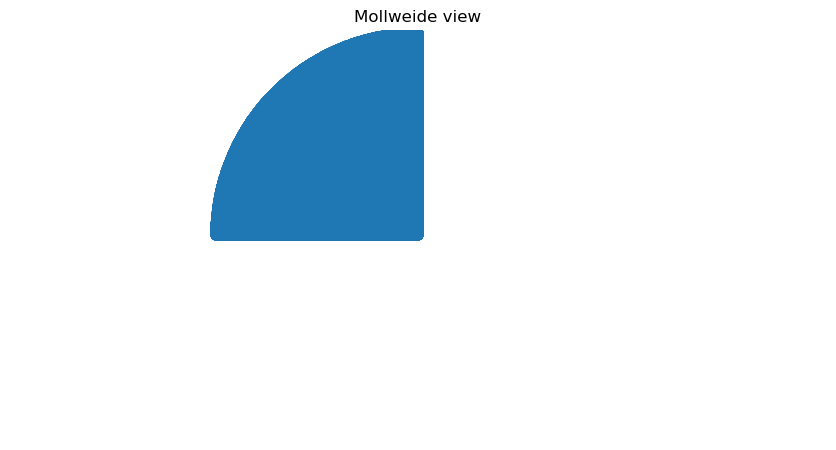

In [95]:
# Visualise HACC-Y1 catalogue
seed = 0
GpAM='0.06'
path='/global/homes/j/jharno/IA-infusion/HACC-Y1/GalCat/StageIV_nz/V0/seed'+str(seed)+'/'

for tomo in range(2,3):
    fname_in='GalCat_tomo'+str(tomo)+'_All_nshells'+str(nshells)+'_'+GpAM+'GpAM_RA_Dec_g1_g2_w_z_good.asc'
    GalCat = np.loadtxt(path+fname_in)
    
    hp.mollview()
    hp.projscatter(GalCat[:,0],GalCat[:,1], lonlat=True)
    plt.show()

/tmp/ipykernel_41560/2162814846.py:2: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fname = path_in+'density_map_'+np.str(snaplist[plane])+'_dens.bin'


Working on file /global/cfs/cdirs/lsst/groups/CS/mass_sheets/density_map_279_dens.bin


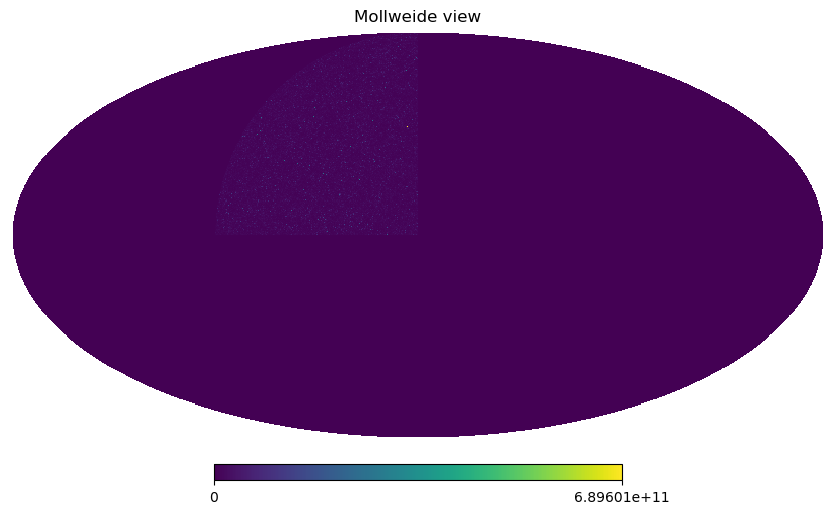

In [38]:
plane=33
fname = path_in+'density_map_'+np.str(snaplist[plane])+'_dens.bin'

print('Working on file '+fname)
tmp = np.fromfile(fname,'<f')

# Format is nested, order into ring in order to use alm2maps transforms
# and degrade NSIDE 
#print("NSIDE_orig=", hp.get_nside(tmp))
#binmap=hp.pixelfunc.ud_grade(tmp, 4096, pess=False, order_in='NESTED', order_out='RING', power=None, dtype=None)
#print("NSIDE_new=", hp.get_nside(binmap))

# Or reorder, keeping all full NSIDE resolution
hpmap_density = hp.reorder(tmp, n2r = True)
del tmp
hp.mollview(hpmap_density, nest=False)
plt.show()


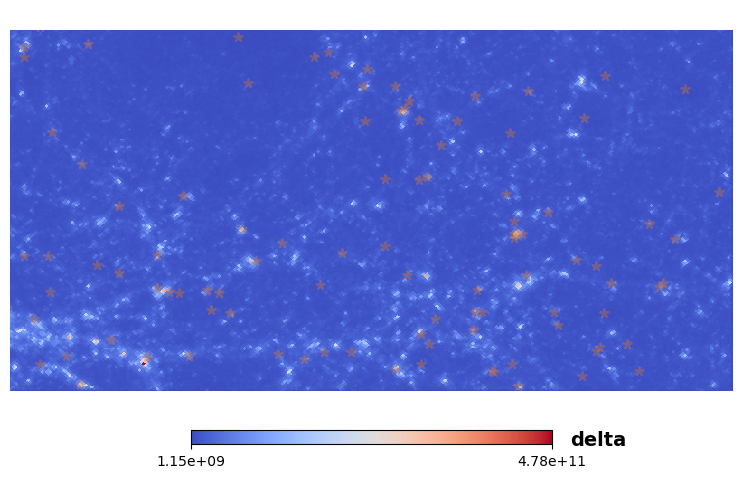

In [47]:
# Visualise SkySim5000 catalogue
lonra = [0, 2]
latra = [0, 1]
hp.cartview(hpmap_density,
    cbar=True, lonra=lonra, latra=latra,
    nest=False,
    title=" ",
    # min=-10, max=0,
    cmap=plt.cm.coolwarm,
    norm=None, unit='delta')
#plt.show()

GpAM='0.06'
path='/global/homes/j/jharno/IA-infusion/SkySim5000/GalCat/StageIV_nz/'



for tomo in range(3,4):
    fname_in='GalCat_tomo'+str(tomo)+'_plane33_'+GpAM+'GpAM_RA_Dec_g1_g2_w_linear_bias.asc'
    GalCat = np.loadtxt(path+fname_in)
    
    #hp.mollview()
    #hp.projscatter(GalCat[:,0],GalCat[:,1], lonlat=True)
    #plt.show()
    
    #hp.cartview(lonra=lonra, latra=latra,
    #            nest=False,
    #            title=" ",
    #            norm=None, unit=None)
    hp.projscatter(GalCat[:,0],GalCat[:,1],lonlat=True,marker=(5, 2),c='tab:orange',alpha=0.3)
    plt.show()
    

In [9]:
# Visualise the mask file
hpmap_weight = hp.fitsfunc.read_map('./IA-infusion/SkySim5000/FullSky_weight.fits', field=0,nest=False, partial=False, hdu=1, h=False, verbose=True, memmap=True)
#
# masking - not really necessary here, but just in case it is useful for something else.
unmask = np.where(hpmap_weight > 0)[0]


NSIDE=8192
pixel_area_arcmin2 = hp.pixelfunc.nside2pixarea(nside=NSIDE)*(180*60/np.pi)**2
octant_area_arcmin2 = sum(unmask)*pixel_area_arcmin2